In [51]:
from matplotlib.pyplot import *
import numpy as np
import pandas as pd
import os
import importlib


from ATARI.sammy_interface import sammy_interface, sammy_classes, sammy_functions, template_creator

from ATARI.models.particle_pair import Particle_Pair

from ATARI.models.experimental_model import experimental_model

from copy import copy


In [52]:
%matplotlib widget

In [53]:
def plot(datasets, experiments, fits, priors=[], true=[]):
    colors = ["C1", "C2", "C3", "C4", "C5", "C6", "C7"]
    fig, axes = subplots(2,1, figsize=(10,7), sharex=True)

    for i, exp in enumerate(experiments):
        if exp.reaction == "transmission":
            model_key = "theo_trans"
            iax = 0
        elif exp.reaction == "capture":
            model_key = "theo_xs"
            iax = 1
        else:
            raise ValueError()

        axes[iax].errorbar(datasets[i].E, datasets[i].exp, yerr=datasets[i].exp_unc, zorder=0,
                                                fmt='.', color=colors[i], linewidth=0.5, markersize=1.5, capsize=1, label=exp.title)
        
        axes[iax].plot(fits[i].E, fits[i][model_key], color=colors[i], lw=1.5, label=f'fit {exp.title}')

        if len(priors) != 0:
            axes[iax].plot(priors[i].E, priors[i][model_key], '--', color=colors[i], lw=1.5) #, label=f'prior {exp.title}')
        if len(true) != 0:
            axes[iax].plot(true[i].E, true[i][model_key], '-', color=colors[i], alpha=0.5, lw=1.5) #, label=f'prior {exp.title}')

        
    axes[0].set_ylabel("T")
    axes[1].set_ylabel(r"$Y_{\gamma}$")

    ### make it pretty
    for ax in axes:
        # ax.set_xlim([200,250])
        ax.set_ylim([-0.1,1.1])
        ax.legend()

    fig.supxlabel('Energy (eV)')
    fig.tight_layout()

    return fig

In [54]:
# sammyRTO = sammy_classes.SammyRunTimeOptions(
#     path_to_SAMMY_exe = '/Users/noahwalton/gitlab/sammy/sammy/build/bin/sammy',
#     sammy_runDIR = 'SAMMY_runDIR',
#     keep_runDIR = True,
#     shell = 'zsh',
#     inptemplate= "readendf.inp",
#     )

sammyRTO = sammy_classes.SammyRunTimeOptions('/Users/noahwalton/gitlab/sammy/sammy/build/bin/sammy',
                             {"Print"   :   True,
                              "bayes"   :   False,
                              "keep_runDIR"     : True
                              })

matnum = 7328
jeff_file = "/Users/noahwalton/research_local/data/JEFF33_endf6/73-Ta-181g.jeff33"
endf_file = "/Users/noahwalton/research_local/data/neutrons_ENDF-B-VII.1/n-073_Ta_181.endf"

endf_parameters = sammy_functions.get_endf_parameters(endf_file, matnum, sammyRTO)
jeff_parameters = sammy_functions.get_endf_parameters(jeff_file, matnum, sammyRTO)

In [55]:
# endf_parameters = endf_parameters[(endf_parameters.E<260) & (endf_parameters.E>190)]
# endf_parameters["varyGn1"] = np.ones(len(endf_parameters))
# endf_parameters["varyGg"] = np.ones(len(endf_parameters))*0
# endf_parameters["varyE"] = np.ones(len(endf_parameters))
# endf_parameters

In [56]:
jeff_parameters = jeff_parameters[(jeff_parameters.E<230) & (jeff_parameters.E>190)]
jeff_parameters["varyGn1"] = np.ones(len(jeff_parameters))
jeff_parameters["varyGg"] = np.ones(len(jeff_parameters))*1
jeff_parameters["varyE"] = np.ones(len(jeff_parameters))
jeff_parameters

,E,Gg,Gn1,varyE,varyGg,varyGn1,J_ID
46,194.80,55.0000,99.5555,1.0,1.0,1.0,2.0
47,200.00,63.0000,31.4285,1.0,1.0,1.0,1.0
48,204.67,64.9999,2.7540,1.0,1.0,1.0,1.0
49,208.48,64.9999,9.4220,1.0,1.0,1.0,2.0
50,215.09,64.9999,48.2700,1.0,1.0,1.0,2.0
51,216.60,64.9999,19.3900,1.0,1.0,1.0,1.0
52,219.81,64.9999,12.8800,1.0,1.0,1.0,2.0
53,222.29,64.9999,2.4360,1.0,1.0,1.0,2.0
54,225.15,64.9999,20.5700,1.0,1.0,1.0,2.0


In [57]:
Ta_pair = Particle_Pair("Ta181",
                        formalism="XCT",
                        ac=8.1271,     # scattering radius
                        M=180.948030,  # amu of target nucleus
                        m=1,           # amu of incident neutron
                        I=3.5,         # intrinsic spin, positive parity
                        i=0.5,         # intrinsic spin, positive parity
                        l_max=2)       # highest order l-wave to consider

Ta_pair.add_spin_group(Jpi='3.0',
                       J_ID=1,
                       D_avg=8.79,
                       Gn_avg=46.5,
                       Gn_dof=1,
                       Gg_avg=64.0,
                       Gg_dof=1000)

Ta_pair.add_spin_group(Jpi='4.0',
                       J_ID=2,
                       D_avg=4.99,
                       Gn_avg=35.5,
                       Gn_dof=1,
                       Gg_avg=64.0,
                       Gg_dof=1000)

### Define individual experiment parameters

In [58]:
erange_all = [200,225]

In [59]:
capdat1 = sammy_functions.readlst("/Users/noahwalton/research_local/resonance_fitting/ATARI_workspace/measurement_data/yield_ta1b_unsmooth.dat")

expcap1 = experimental_model(   "cap1",
                                "capture", 
                                # [190, 260],
                                erange_all,
                                inputs={},
                                parameters = {'n':(0.005631, 0),  'FP':(45.27, 0.05),  'burst':(8.0,1.0), 'temp':(294.2610, 0.0)},
                                channel_width_info={
                                    "maxE": [270], 
                                    "chw": [102.7],
                                    "dchw": [0.8]
                                }
                               )

capdat1 = capdat1[(capdat1.E<max(expcap1.energy_range)) & (capdat1.E>min(expcap1.energy_range))]

In [60]:
capdat2 = sammy_functions.readlst("/Users/noahwalton/research_local/resonance_fitting/ATARI_workspace/measurement_data/yield_ta2_unsmooth.dat")
expcap2 = experimental_model(   "cap2",
                                "capture", 
                                # [190, 260],
                                erange_all,
                                inputs={},
                                parameters = {'n':(0.011179, 0.0),  'FP':(45.27, 0.05),  'burst':(8.0,1.0), 'temp':(294.2610, 0.0)},
                                channel_width_info={
                                    "maxE": [270], 
                                    "chw": [102.7],
                                    "dchw": [0.8]
                                }
                               )
capdat2 = capdat2[(capdat2.E<max(expcap2.energy_range)) & (capdat2.E>min(expcap2.energy_range))]

In [61]:
from ATARI.theory.experimental import e_to_t, t_to_e
tof2 = e_to_t(capdat2.E, 45.27, True)
dt2 = np.diff(tof2*1e6)
tof1 = e_to_t(capdat1.E, 45.27, True)
dt1 = np.diff(tof1*1e6)

print(np.unique(np.round(dt1, 4)))
print(np.unique(np.round(dt2, 4)))

[0.1027]
[0.1027]


In [62]:
transdat12 = sammy_functions.readlst("/Users/noahwalton/research_local/resonance_fitting/ATARI_workspace/measurement_data/trans-Ta-12mm.dat")
exptrans12 = experimental_model("trans12",
                                "transmission",
                                # [190, 260],
                                erange_all,

                                inputs = {
                                    'alphanumeric'       :   ["BROADENING IS WANTED"],
                                    'ResFunc'            :   "ORRES"
                                        },

                                parameters = {
                                    'n':(0.067166, 0.0),  
                                    'FP':(35.185,0.0), 
                                    'burst':(8,0.0), 
                                    'temp':(294.2610, 0.0)},

                                channel_width_info={
                                        "maxE": [270], 
                                        "chw": [102.7],
                                        "dchw": [0.8]
                                        },

                                additional_resfunc_lines=["WATER 0004 5.6822000 -0.54425 0.07733000", "WATER      0.5000000  0.05000 0.00700000", "LITHI 000  -1.000000  -1.0000 6.00000000", "LITHI      0.1000000  0.10000 0.60000000", "LITHI      166.87839 -28.7093 1.260690", "LITHI      0.2574580 -0.06871 0.004915"]
                               )

transdat12 = transdat12[(transdat12.E<max(exptrans12.energy_range)) & (transdat12.E>min(exptrans12.energy_range))]


In [63]:
transdat1 = sammy_functions.readlst("/Users/noahwalton/research_local/resonance_fitting/ATARI_workspace/measurement_data/trans-Ta-1mm.twenty")
exptrans1 = experimental_model("trans1",
                               "transmission", 
                            #    [190, 260],
                            erange_all,
                            
                               inputs={},

                               parameters = {'n':(0.00566,0.0),  'FP':(100.14,0.0), 'burst':(8, 0.0), 'temp':(294.2610, 0.0)},

                               channel_width_info={
                                    "maxE": [216.16, 613.02], 
                                    "chw": [204.7, 102.4],
                                    "dchw": [1.6, 1.6]
                                }
                                
                               )
transdat1 = transdat1[(transdat1.E<max(exptrans1.energy_range)) & (transdat1.E>min(exptrans1.energy_range))]


In [64]:
# transdat3 = sammy_functions.readlst("/Users/noahwalton/research_local/resonance_fitting/ATARI_workspace/measurement_data/trans-Ta-3mm.twenty")
# transdat3 = transdat3[(transdat3.E<260) & (transdat3.E>190)]
# exptrans3 = sammy_classes.experiment([180, 270], "transmission", 
#                                inputs={},
#                                parameters = {'n':0.017131,  'FP':100.14, 'bw':0.025, 'burst':8},
#                                uncertainty= {               'FP':0.01,  'bw':0.0016,'burst':1}
#                                )

In [65]:
# transdat6 = sammy_functions.readlst("/Users/noahwalton/research_local/resonance_fitting/ATARI_workspace/measurement_data/trans-Ta-6mm.twenty")
# transdat6 = transdat6[(transdat6.E<260) & (transdat6.E>190)]
# exptrans6 = sammy_classes.experiment([180, 270], "transmission", 
#                                inputs={},
#                                parameters = {'n':0.03356,  'FP':100.14, 'bw':0.025, 'burst':8},
#                                uncertainty= {               'FP':0.01,  'bw':0.0016,'burst':1}
#                                )


In [66]:
# tof1 = e_to_t(transdat1.E, 100.14, True)
# dt1 = np.diff(tof1*1e6)
# tof2 = e_to_t(transdat3.E, 100.14, True)
# dt2 = np.diff(tof2*1e6)
# tof3 = e_to_t(transdat6.E, 100.14, True)
# dt3 = np.diff(tof3*1e6)

# print(np.unique(np.round(dt1,4)))
# print(np.unique(np.round(dt2,4)))
# print(np.unique(np.round(dt3,4)))
# np.argwhere(np.round(dt1,4)==0.1536)
# transdat3.iloc[423, :]

In [96]:
importlib.reload(sammy_classes)
importlib.reload(sammy_functions)
importlib.reload(template_creator)

<module 'ATARI.sammy_interface.template_creator' from '/Users/noahwalton/Documents/GitHub/ATARI/ATARI/sammy_interface/template_creator.py'>

## Fit from endf or jeff to ensure that the experimental models are correct

In [97]:
datasets = [capdat1, capdat2, transdat1, transdat12]#, transdat3, transdat6]
experiments= [expcap1, expcap2, exptrans1, exptrans12]#, exptrans3, exptrans6]

rto = sammy_classes.SammyRunTimeOptions('/Users/noahwalton/gitlab/sammy/sammy/build/bin/sammy',
                             {"Print"   :   True,
                              "bayes"   :   True,
                              "keep_runDIR"     : True
                              })

# model = sammy_classes.theory("Ta181", 180.948030, ac=8.1271, formalism="XCT")
# model = sammy_classes.theory("Ta181", 180.948030, ac=7.8, formalism="XCT")



templates = []
for data, exp in zip(datasets, experiments):

    filepath = f'template_{exp.title}_edited'
    # template_creator.make_input_template(filepath, model, exp, rto)  # templates are already made and edited!
    templates.append(os.path.realpath(filepath))

In [105]:


sammyINPyw = sammy_classes.SammyInputDataYW(
    particle_pair = Ta_pair,
    # resonance_ladder = initial_reslad,  
    resonance_ladder = jeff_parameters,  

    datasets= datasets,
    templates= templates,
    experiments = experiments,
    
    max_steps = 10,
    iterations = 2,
    step_threshold = 0.1,
    autoelim_threshold = None,

    LS = False,
    LevMar = True,
    LevMarV = 2,
    initial_parameter_uncertainty = 1.0
    )



In [106]:
sammyOUT = sammy_functions.run_sammy_YW(sammyINPyw, rto)
# !!! sammyrto bayes is getting overridden!!!

Stepping until convergence
chi2 values
step fudge: ['cap1', 'cap2', 'trans1', 'trans12', 'sum']
0    1.0  : [2.524, 2.3586, 0.6748, 8.3689, 13.9264]
1    2.0  : [3.384, 2.8318, 1.0824, 1.3198, 8.6179]
2    4.0  : [3.0687, 2.6151, 1.1232, 1.3637, 8.1706]
Repeat step 3, 	fudge: ['cap1', 'cap2', 'trans1', 'trans12', 'sum']
		2.0  : [3.1308, 2.7672, 1.1204, 1.4849, 8.5033]
		1.0  : [3.0521, 2.6369, 1.1311, 1.4057, 8.2258]
		0.5  : [2.968, 2.5402, 1.1497, 1.3403, 7.9983]
3    0.5  : [2.968, 2.5402, 1.1497, 1.3403, 7.9983]
Repeat step 4, 	fudge: ['cap1', 'cap2', 'trans1', 'trans12', 'sum']
		0.25 : [2.9611, 2.5281, 1.1398, 1.393, 8.022]
		0.125: [2.9512, 2.5111, 1.1542, 1.3306, 7.9471]
4    0.125: [2.9512, 2.5111, 1.1542, 1.3306, 7.9471]
Chi2 improvement below threshold


In [107]:
# prior_lsts = lsts
print(sammyOUT.chi2, np.sum(sammyOUT.chi2))
print(sammyOUT.chi2_post, np.sum(sammyOUT.chi2_post))

[2.52404, 2.35865, 0.674819, 8.36886] 13.926369000000001
[2.95122, 2.51106, 1.15421, 1.33061] 7.9471


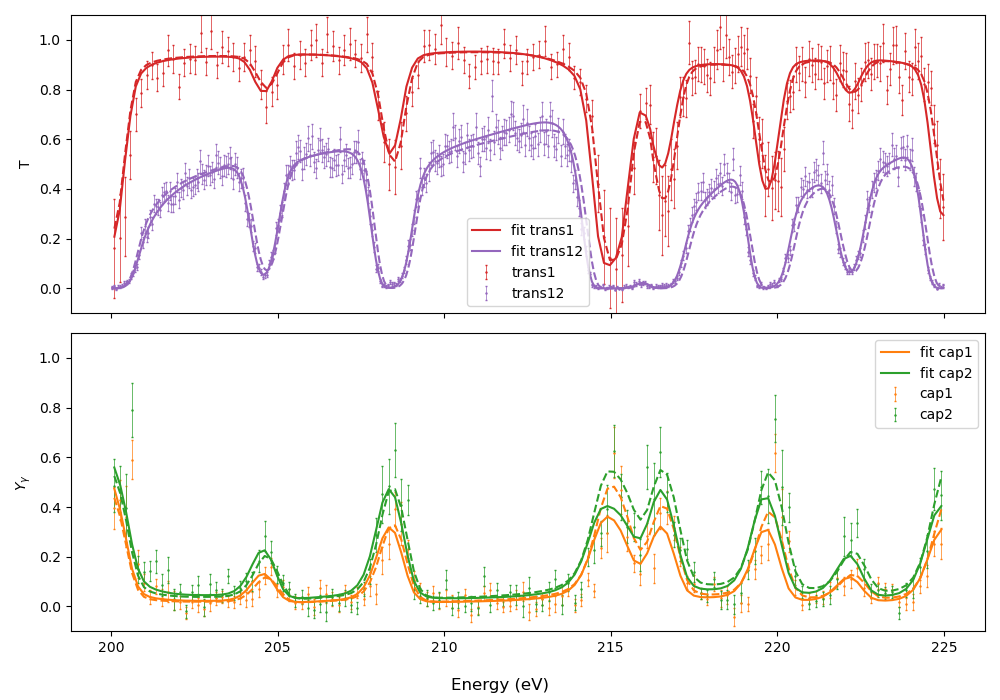

In [ ]:
fig = plot(datasets, experiments, sammyOUT.pw_post, priors=sammyOUT.pw)
fig.tight_layout()

### Now, generate synthetic datasets modelled after each dataset you have

In [ ]:
# from ATARI.theory.resonance_statistics import make_res_par_avg

# ac = 0.81271    # scattering radius in 1e-12 cm 
# M = 180.948030  # amu of target nucleus
# m = 1           # amu of incident neutron
# I = 3.5         # intrinsic spin, positive parity
# i = 0.5         # intrinsic spin, positive parity
# l_max = 1       # highest order l-wave to consider


# spin_groups = [ (3.0,1,0)]  # ,  (4.0,1,0)]
# res_par_avg_1 = make_res_par_avg(J_ID=1,
#                                  D_avg = 8.79, 
#                             Gn_avg= 46.4, #0.658, 
#                             n_dof = 1, 
#                             Gg_avg = 64.0, 
#                             g_dof = 1000, 
#                             print = False)

# res_par_avg_2 = make_res_par_avg(J_ID=2,
#                                  D_avg = 4.99, 
#                             Gn_avg= 35.5, #0.658, 
#                             n_dof = 1, 
#                             Gg_avg = 64.0, 
#                             g_dof = 1000, 
#                             print = False)

# average_parameters = {'3.0':res_par_avg_1}
# Ta_pair = Particle_Pair( ac, M, m, I, i, l_max,
#                                 input_options={},
#                                 spin_groups=spin_groups,
#                                 average_parameters=average_parameters )   


In [ ]:
# from ATARI.syndat.transmission_rpi import syndat_T
# from ATARI.syndat.yield_rpi import syndat_Y

# ### In the future this code block will be inside of syndat 
# # Also, currently this is not sampling resonance parameters


# synthetic_data_dfs = []
# for i, exp in enumerate(experiments):

#     true_df = copy(sammyOUT.pw_post[i])
#     if exp.reaction == "transmission":
#         true = "theo_trans"
#         syndat = syndat_T()
#     elif exp.reaction == "capture":
#         true = "theo_xs"
#         syndat = syndat_Y()
#     else:
#         raise ValueError()

#     true_df = true_df[["E",true]]
#     true_df.rename(columns={true:"true"}, inplace=True)

#     syndat.run(true_df)
#     synthetic_data_dfs.append(syndat.data)

    

In [ ]:

# fig, axes = subplots(2,1, figsize=(8,6), sharex=True)


# for i, exp in enumerate(experiments):
    
#     if exp.reaction == "transmission":

#         axes[0].errorbar(synthetic_data_dfs[i].E, synthetic_data_dfs[i].exp, yerr=synthetic_data_dfs[i].exp_unc, zorder=0,
#                                                 fmt='.', color='darkgreen', linewidth=0.5, markersize=1.5, capsize=1, label='12mm')

#         axes[0].plot(synthetic_data_dfs[i].E, synthetic_data_dfs[i].true)
        
#     elif exp.reaction == "capture":
    
#         axes[1].errorbar(synthetic_data_dfs[i].E, synthetic_data_dfs[i].exp, yerr=synthetic_data_dfs[i].exp_unc, zorder=0, 
#                                                 fmt='.', color='indigo', linewidth=0.5, markersize=1.5, capsize=1, label='1mm')
#         axes[1].plot(synthetic_data_dfs[i].E, synthetic_data_dfs[i].true)


# axes[0].set_ylabel("T")
# axes[1].set_ylabel(r"$Y_{\gamma}$")

# ### make it pretty
# for ax in axes:
#     ax.set_xlim([200,250])
#     ax.set_ylim([-0.1,1.1])
#     ax.legend()

# fig.supxlabel('Energy (eV)')
# fig.tight_layout()

### Now fit synthetic or real data with automated evaluator

In [ ]:
from ATARI.theory.resonance_statistics import make_res_par_avg

def get_parameter_grid(energy_grid, res_par_avg, num_Er, option=0):

    # allow Elambda to be just outside of the window
    max_Elam = max(energy_grid) + res_par_avg['Gt99']/10e3
    min_Elam = min(energy_grid) - res_par_avg['Gt99']/10e3

    if option == 1:
        Gn = np.repeat(res_par_avg["Gn01"], num_Er)*10
        Gg = np.repeat(res_par_avg["<Gg>"], num_Er)
    else:
        Gn = np.repeat(res_par_avg["Gn01"], num_Er)*1000
        Gg = np.repeat(res_par_avg["<Gg>"], num_Er)
        
    Er = np.linspace(              min_Elam,              max_Elam,                num_Er)
    J_ID = np.repeat(res_par_avg["J_ID"], num_Er)

    return Er, Gg, Gn, J_ID

def get_resonance_ladder(Er, Gg, Gn1, J_ID, varyE=1, varyGg=1, varyGn1=1):
    return pd.DataFrame({"E":Er, "Gg":Gg, "Gn1":Gn1, "varyE":np.ones(len(Er))*varyE, "varyGg":np.ones(len(Er))*varyGg, "varyGn1":np.ones(len(Er))*varyGn1 ,"J_ID":J_ID})

spin_groups = [ (3.0,1,0) ,  (4.0,1,0)]
res_par_avg_1 = make_res_par_avg(J_ID=1,
                            D_avg = 8.79, 
                            Gn_avg= 46.4, #0.658, 
                            n_dof = 1, 
                            Gg_avg = 64.0, 
                            g_dof = 1000, 
                            print = False)
res_par_avg_2 = make_res_par_avg(J_ID=2,
                            D_avg = 4.99, 
                            Gn_avg= 35.5, #0.658, 
                            n_dof = 1, 
                            Gg_avg = 64.0, 
                            g_dof = 1000, 
                            print = False)

ac = 0.81271; M = 180.948030; m = 1; I = 3.5; i = 0.5; l_max = 1 
average_parameters = {'3.0':res_par_avg_1, '4.0':res_par_avg_2}

Ta_pair = Particle_Pair( ac, M, m, I, i, l_max,
                                input_options={},
                                spin_groups=spin_groups,
                                average_parameters=average_parameters )   

num_Er = 60
Er_1, Gg_1, Gn_1, J_ID_1 = get_parameter_grid(erange_all, res_par_avg_1, num_Er, option=1)
Er_2, Gg_2, Gn_2, J_ID_2 = get_parameter_grid(erange_all, res_par_avg_2, 0, option=1)
# Er_2 = Er_2

Er = np.concatenate([Er_1, Er_2])
Gg = np.concatenate([Gg_1, Gg_2])
Gn = np.concatenate([Gn_1, Gn_2])
J_ID = np.concatenate([J_ID_1, J_ID_2])
initial_reslad = get_resonance_ladder(Er, Gg, Gn, J_ID, varyE=0, varyGg=0, varyGn1=1)

In [ ]:
# print(Er_1)
# print(Er_2+1.5/2)
# np.unique(np.diff(Er_1))

In [ ]:

sammyINPyw = sammy_classes.SammyInputDataYW(
    particle_pair = Ta_pair,
    model = model, 
    resonance_ladder = initial_reslad,  

    datasets= datasets,
    templates= templates,
    experiments = experiments,
    
    max_steps = 20,
    iterations = 2,
    step_threshold = 0.1,
    autoelim_threshold = None,

    LS = False,
    LevMar = True,
    LevMarV = 1.5,
    initial_parameter_uncertainty = 0.5
    )


In [ ]:
sammyOUT_fit = sammy_functions.run_sammy_YW(sammyINPyw, rto)

Stepping until convergence
chi2 values
step fudge: ['cap1', 'cap2', 'trans1', 'trans12', 'sum']
0    0.5  : [8.1989, 9.848, 5.3253, 2391.19, 2414.5622]
1    0.75 : [3.1643, 3.1054, 2.3857, 17.3233, 25.9787]
2    1.125: [3.0916, 2.9938, 1.5194, 1.5886, 9.1935]
3    1.688: [2.9209, 2.8882, 1.2339, 1.5181, 8.5611]
Repeat step 4, 	fudge: ['cap1', 'cap2', 'trans1', 'trans12', 'sum']
		1.125: [2.9028, 2.9074, 1.1703, 1.5434, 8.5239]
4    1.125: [2.9028, 2.9074, 1.1703, 1.5434, 8.5239]
Chi2 improvement below threshold


In [ ]:
sammyOUT_fit.chi2_post

[1.76711, 1.84329, 0.655753, 1.48716]

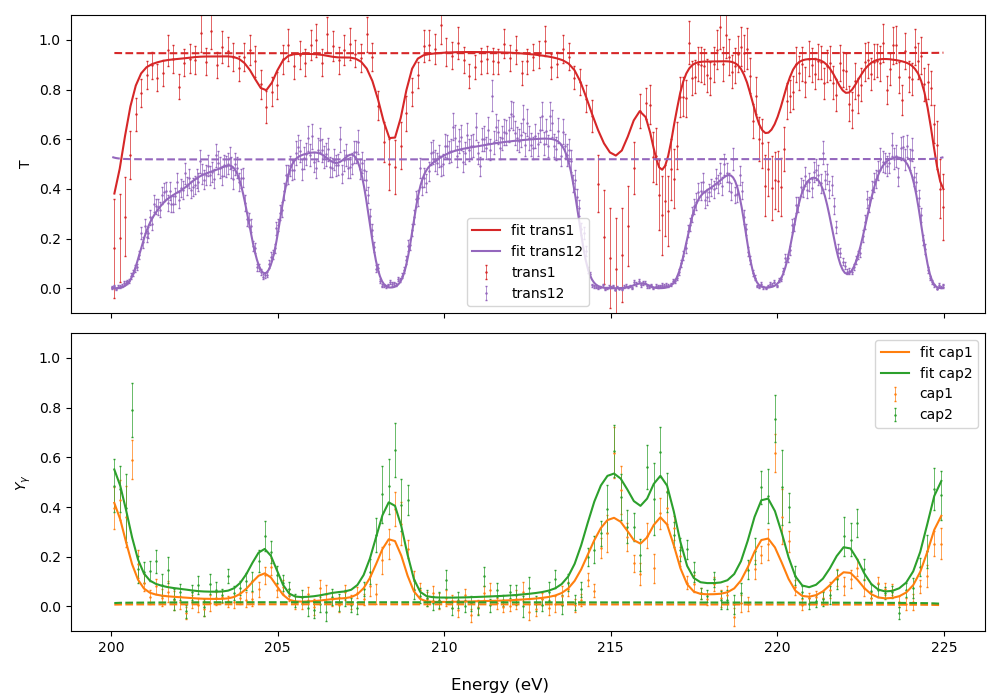

In [ ]:
fig = plot(datasets, experiments, sammyOUT_fit.pw_post, priors=sammyOUT_fit.pw)
fig.tight_layout()

In [ ]:
test = sammyOUT_fit.par_post

In [ ]:
thresh = 1e0
print(np.count_nonzero(sammyOUT_fit.par_post.Gn1>thresh))
par2 =copy(sammyOUT_fit.par_post)
par2 = par2[par2.Gn1>thresh]
par2["varyE"] = np.ones(len(par2))
par2["varyGg"] = np.ones(len(par2))
par2

14


,E,Gg,Gn1,varyE,varyGg,varyGn1,J_ID
0,199.962129,64.0,17.312089,1.0,1.0,1.0,1.0
1,200.387142,64.0,2.771147,1.0,1.0,1.0,1.0
11,204.637268,64.0,2.936794,1.0,1.0,1.0,1.0
19,208.037368,64.0,1.361213,1.0,1.0,1.0,1.0
20,208.462381,64.0,8.300510,1.0,1.0,1.0,1.0
34,214.412557,64.0,2.474354,1.0,1.0,1.0,1.0
35,214.837569,64.0,5.304430,1.0,1.0,1.0,1.0
36,215.262582,64.0,7.250879,1.0,1.0,1.0,1.0
37,215.687594,64.0,2.286825,1.0,1.0,1.0,1.0
39,216.537619,64.0,12.938282,1.0,1.0,1.0,1.0


In [ ]:
sammyINPyw.resonance_ladder = par2
sammyOUT_fit2 = sammy_functions.run_sammy_YW(sammyINPyw, rto)

Stepping until convergence
chi2 values
step fudge: ['cap1', 'cap2', 'trans1', 'trans12', 'sum']
0    0.5  : [2.9684, 2.9804, 1.2587, 4.7109, 11.9184]
1    0.75 : [2.4535, 2.2893, 1.0713, 1.2675, 7.0816]
2    1.125: [2.1833, 2.0931, 1.0308, 1.2043, 6.5115]
Repeat step 3, 	fudge: ['cap1', 'cap2', 'trans1', 'trans12', 'sum']
		0.75 : [2.4594, 2.3499, 1.0866, 1.3456, 7.2415]
		0.5  : [2.2111, 2.1508, 1.1361, 1.2199, 6.7179]
		0.333: [2.172, 2.0804, 1.0409, 1.1785, 6.4717]
3    0.333: [2.172, 2.0804, 1.0409, 1.1785, 6.4717]
Chi2 improvement below threshold


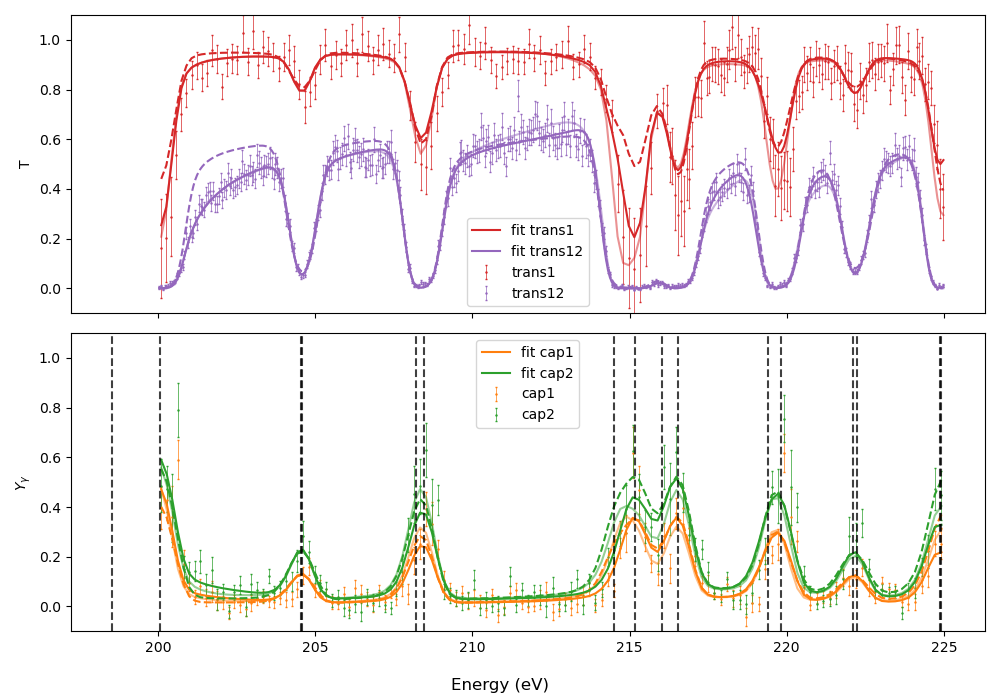

In [ ]:
fig = plot(datasets, experiments, sammyOUT_fit2.pw_post, priors=sammyOUT_fit2.pw, true=sammyOUT.pw_post)
ax = fig.gca()
for i,r in sammyOUT_fit2.par_post.iterrows():
    ax.axvline(r.E, ymin=0, ymax=1, linestyle='--', alpha=0.75, color='k')
fig.tight_layout()

In [ ]:
sammyOUT_fit2.par_post

,E,Gg,Gn1,varyE,varyGg,varyGn1,J_ID
0,198.542421,299.669694,46.925940,1.0,1.0,1.0,1.0
1,200.062792,41.918583,25.556471,1.0,1.0,1.0,1.0
2,204.582433,61.846752,2.160653,1.0,1.0,1.0,1.0
3,204.546710,79.928638,0.982806,1.0,1.0,1.0,1.0
4,208.193619,2.561694,2.655675,1.0,1.0,1.0,1.0
5,208.471740,101.234793,6.788632,1.0,1.0,1.0,1.0
6,214.504531,-0.359951,4.323537,1.0,1.0,1.0,1.0
7,215.160293,32.573521,32.669224,1.0,1.0,1.0,1.0
8,216.030140,69.838878,1.268286,1.0,1.0,1.0,1.0
9,216.552098,101.679594,13.736491,1.0,1.0,1.0,1.0


In [ ]:
jeff_parameters

,E,Gg,Gn1,varyE,varyGg,varyGn1,J_ID
46,194.80,55.0000,99.5555,1.0,1.0,1.0,2.0
47,200.00,63.0000,31.4285,1.0,1.0,1.0,1.0
48,204.67,64.9999,2.7540,1.0,1.0,1.0,1.0
49,208.48,64.9999,9.4220,1.0,1.0,1.0,2.0
50,215.09,64.9999,48.2700,1.0,1.0,1.0,2.0
51,216.60,64.9999,19.3900,1.0,1.0,1.0,1.0
52,219.81,64.9999,12.8800,1.0,1.0,1.0,2.0
53,222.29,64.9999,2.4360,1.0,1.0,1.0,2.0
54,225.15,64.9999,20.5700,1.0,1.0,1.0,2.0


In [ ]:

par3 =copy(sammyOUT_fit2.par_post)
par3 = par3.iloc[[0,1,2,5,7,9,11,12,15], :]
par3.iloc[[0,3,4,6,7,8], 6] = 2.0
par3

,E,Gg,Gn1,varyE,varyGg,varyGn1,J_ID
0,198.542421,299.669694,46.925940,1.0,1.0,1.0,2.0
1,200.062792,41.918583,25.556471,1.0,1.0,1.0,1.0
2,204.582433,61.846752,2.160653,1.0,1.0,1.0,1.0
5,208.471740,101.234793,6.788632,1.0,1.0,1.0,2.0
7,215.160293,32.573521,32.669224,1.0,1.0,1.0,2.0
9,216.552098,101.679594,13.736491,1.0,1.0,1.0,1.0
11,219.818205,40.550951,9.613492,1.0,1.0,1.0,2.0
12,222.114667,32.917088,1.928822,1.0,1.0,1.0,2.0
15,224.888341,15.019436,11.652276,1.0,1.0,1.0,2.0


In [ ]:

sammyINPyw.resonance_ladder = par3
sammyOUT_fit3 = sammy_functions.run_sammy_YW(sammyINPyw, rto)

Stepping until convergence
chi2 values
step fudge: ['cap1', 'cap2', 'trans1', 'trans12', 'sum']
0    0.5  : [1.9616, 1.9702, 0.9951, 30.0182, 34.9451]
1    0.75 : [3.6159, 3.0382, 0.982, 1.563, 9.1991]
2    1.125: [3.1806, 2.584, 1.0871, 1.311, 8.1627]
Repeat step 3, 	fudge: ['cap1', 'cap2', 'trans1', 'trans12', 'sum']
		0.75 : [3.0757, 2.5451, 1.1353, 1.3711, 8.1272]
3    0.75 : [3.0757, 2.5451, 1.1353, 1.3711, 8.1272]
Chi2 improvement below threshold


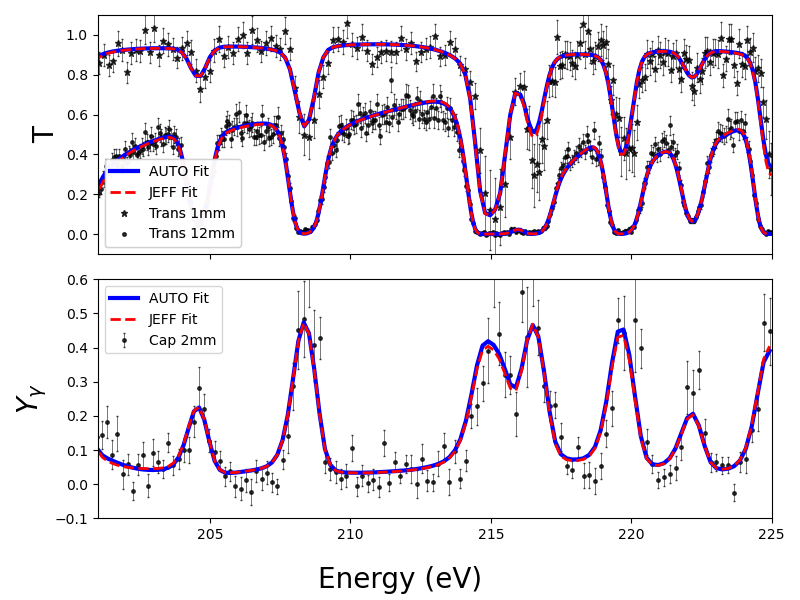

In [ ]:
# fig = plot(datasets, experiments, sammyOUT_fit3.pw_post, priors=sammyOUT.pw_post)

# colors = ["C1", "C2", "C3", "C4", "C5", "C6", "C7"]
# colors = ["blue", "darkblue","blue", "darkblue"]
colors = ["k", "k","k", "k"]

# colors2 = ["crimson","red", "crimson", "red"]
colors2 = ["red","red", "red", "red"]

fmts = ['.','.','*','.']

alphas = [1.0,1.0,1.0,1.0]
# alphas=[1.0]*4
fig, axes = subplots(2,1, figsize=(8,6), sharex=True)

for i, exp in enumerate(experiments):
    if exp.reaction == "transmission":
        model_key = "theo_trans"
        iax = 0
    elif exp.reaction == "capture":
        model_key = "theo_xs"
        iax = 1
    else:
        raise ValueError()
    
    if i == 0:
        pass
    else:

        axes[iax].errorbar(datasets[i].E, datasets[i].exp, yerr=datasets[i].exp_unc, zorder=0,
                                                fmt=fmts[i], color=colors[i], alpha=0.75, linewidth=0.5, markersize=5.0, capsize=0.5, label=exp.title)
        
        axes[iax].plot(sammyOUT_fit3.pw_post[i].E, sammyOUT_fit3.pw_post[i][model_key], color='b', lw=3.0, label=f'Auto {exp.title}', zorder=1,  alpha=alphas[i])

        axes[iax].plot(sammyOUT.pw_post[i].E, sammyOUT.pw_post[i][model_key], linestyle='dashed', color=colors2[i], lw=2.0, label=f'JEFF {exp.title}',zorder=2, alpha=alphas[i]) #, label=f'prior {exp.title}')

    
axes[0].set_ylabel("T", fontsize=20)
axes[1].set_ylabel(r"$Y_{\gamma}$", fontsize=20)

### make it pretty
for ax in axes:
    ax.set_xlim([201,225])
    ax.set_ylim([-0.1,1.1])
    # ax.legend(loc='upper left')
axes[1].set_ylim([-0.1, 0.6])

fig.supxlabel('Energy (eV)', fontsize=20)


# for i,r in sammyOUT_fit3.par_post.iterrows():
#     ax.axvline(r.E, ymin=0, ymax=1, linestyle='--', alpha=0.75, color='k')

# lines = axes[1].get_lines()
# legend1 = legend([lines[i] for i in [0,5]],["Cap 1mm", "Cap 2mm"], loc=0)
# legend1 = legend([lines[i] for i in [0,4]],["Cap 2mm"], loc=0)
axes[1].legend([r"AUTO Fit", r"JEFF Fit", "Cap 2mm"], loc="upper left")
# axes[1].add_artist(legend1)


lines = axes[0].get_lines()

# legend2 = axes[0].legend([lines[i] for i in [0,5]], ["Trans 1mm", "Trans 12mm"], loc="lower left")
legend2 = axes[0].legend([lines[i] for i in [3,4, 0,5]], [r"AUTO Fit", r"JEFF Fit","Trans 1mm", "Trans 12mm"], loc="lower left")

axes[0].add_artist(legend2)
# axes[0].legend([r"AUTO Fit", r"JEFF Fit", '','',"Trans 1mm", "Trans 12mm"], loc="lower right")

# for handle in legend1.legendHandles:
#     handle.set_sizes([100])


fig.tight_layout()

In [ ]:
len(lines)

10

In [ ]:
jeff_parameters

,E,Gg,Gn1,varyE,varyGg,varyGn1,J_ID
46,194.80,55.0000,99.5555,1.0,1.0,1.0,2.0
47,200.00,63.0000,31.4285,1.0,1.0,1.0,1.0
48,204.67,64.9999,2.7540,1.0,1.0,1.0,1.0
49,208.48,64.9999,9.4220,1.0,1.0,1.0,2.0
50,215.09,64.9999,48.2700,1.0,1.0,1.0,2.0
51,216.60,64.9999,19.3900,1.0,1.0,1.0,1.0
52,219.81,64.9999,12.8800,1.0,1.0,1.0,2.0
53,222.29,64.9999,2.4360,1.0,1.0,1.0,2.0
54,225.15,64.9999,20.5700,1.0,1.0,1.0,2.0


In [ ]:
# print(len(sammyOUT_fit2.par_post[sammyOUT_fit2.par_post.Gn1>1e-1]))
# par3 =copy(sammyOUT_fit2.par_post)
# par3 = par3[par3.Gn1>1e-1]
# par3["varyE"] = np.ones(len(par3))*0
# par3["varyGg"] = np.ones(len(par3))*1
# par3["varyGn1"] = np.ones(len(par3))*1

# ext_res = copy(par3.iloc[0:2,:])
# ext_res["E"] = [180, 270]
# ext_res["Gg"] = [1000, 1000]
# ext_res["varyGg"] = [1, 1]
# ext_res["varyGn1"] = [1, 1]

# par3 = pd.concat([ext_res.iloc[0:1,:], par3, ext_res.iloc[1:2,:]], ignore_index=True)
# par3

In [ ]:
# sammyINPyw.resonance_ladder = par3
# sammyOUT_fit3 = sammy_functions.run_sammy_YW(sammyINPyw, rto)

In [ ]:
# print(len(sammyOUT_fit3.par_post[sammyOUT_fit3.par_post.Gn1>1e-1]))
# print(len(jeff_parameters))

In [ ]:
# fig = plot(datasets, experiments, sammyOUT_fit3.pw_post, priors=sammyOUT_fit3.pw, true=sammyOUT.pw)
# fig.tight_layout()

### Next steps

Before giving this to oleksii for AIC, I could fit background with external resonances
1. fix the result above
2. add external resonances on either side of the window with fixed energies
3. Fit external resonance widths to capture background
4. give results to Oleksii where AIC will eliminate and re-fit all internal resonance parameters and only widths of external resonances
